# Example 2: Solving Constraints of $U(1)$ BF-theory: working in the gauge invariant Hilbert space

*Author: Waleed Sherif (FAU Erlangen-Nürnberg)*

**Pre-requisite:** See the $U(1)$ BF-theory toy model [tutorial](/docs/Tutorials/U1_BFTheory.ipynb)

In this tutorial, we introduce the basic tools of solving constraints in the gauge invariant Hilbert space. We will once again consider the $U(1)$ BF-theory toy model solved in this [tutorial](/docs/Tutorials/U1_BFTheory.ipynb). This basic usage will include:
- Defining gauge invariant Hilbert spaces
- Using a gauge invariant Metropolis sampler

This basic introduction is supposed to help understand how to build and address more complex systems of interest and solve them in the gauge invariant Hilbert space. The advantage gained here is that the dimensions of the gauge invariant Hilbert space are *far* smaller than the full Hilbert space, hence *drastically* reducing the computational costs.

## 0.0 The quantum $U_q(1)$ BF-Theory revisited

As we saw in the previous tutorial, this toy model has two constraints: the curvature constraint $\hat{F}$ and the Gauß constraint $\hat{G}$. As we will now work in the gauge invariant subspace, we can drop the Gauß term from our constraint, and hence the constraint we solve in this tutorial is simply
$$
\hat{C} = \hat{F}
$$

where we recall that (see [this paper](https://arxiv.org/pdf/2402.10622) for details)

$$
\hat{F} = \sum_{\alpha \in L(\gamma)} (\hat{h}_{\alpha} - \mathbb{I})(\hat{h}^{\dagger}_{\alpha} - \mathbb{I}),
$$

## 1.0 Installing neuraLQX

The first step is installing neuraLQX. This can be done using ``pip`` by executing the following command in your terminal/command line tool:

`>>> pip install --upgrade pip`


`>>> pip install neuralqx`

Once installed, you can simply import `neuralqx` in your Jupyter or python script as

In [1]:
import neuralqx as nqx

[ax90ymed.vpn.rrze.uni-erlangen.de:35316] shmem: mmap: an error occurred while determining whether or not /var/folders/xg/bdgwxkwj0jn0zlwmbt50xfzw0000gn/T//ompi.ax90ymed.501/jf.0/3027632128/sm_segment.ax90ymed.501.b4760000.0 could be created.


## 2.0 Defining the graph

The starting point is always defining a graph. As we know, we can do this using the `GraphHandler` class found in the `graph` module of neuraLQX. We will use the same graph considered in the previous tutorial.

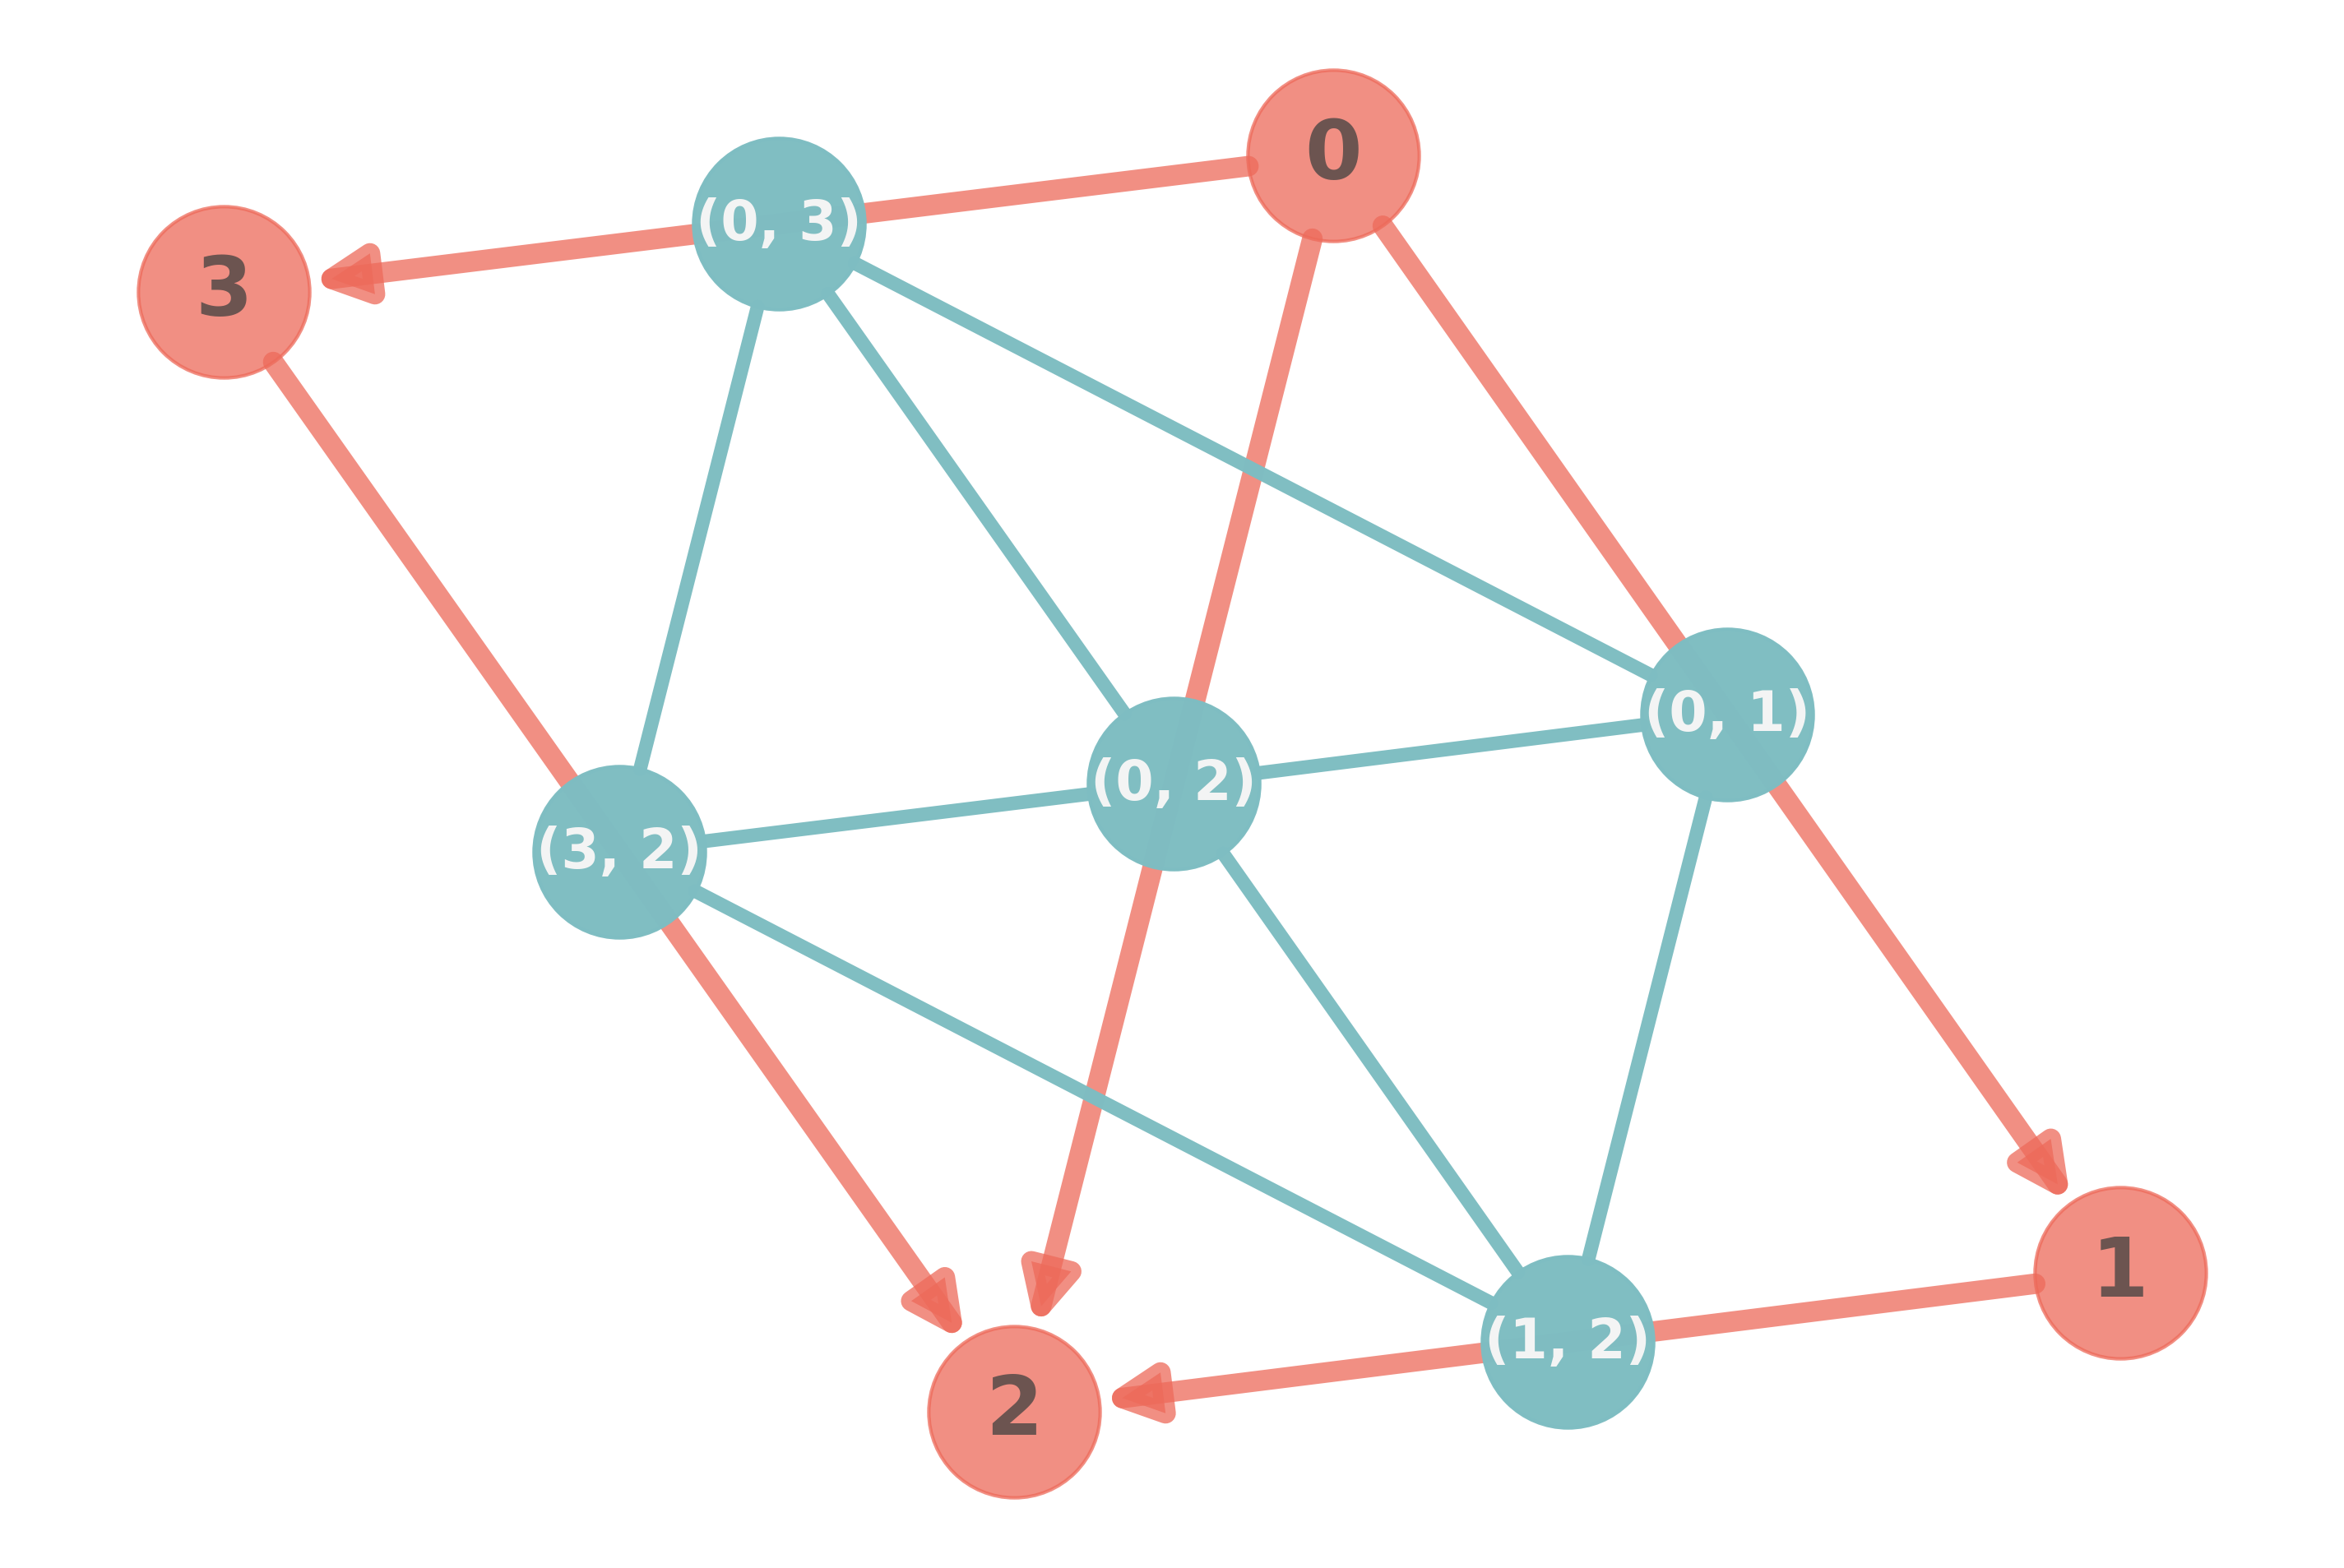

In [2]:
edges = [[0, 1], [0, 2], [0, 3], [1, 2], [3, 2]]

graph = nqx.graph.GraphHandler(edges = edges, plot = True)

Now, let us take a moment to analyse this graph. As it stands the kinematical Hilbert space is of dimensions
$$
\dim \mathcal{H} = (2 m_{max} + 1)^{\mid E(\gamma)\mid}
$$
where $\mid E(\gamma)\mid = 5$.

We now need to derive a gauge fixing. Since the Gauß constraint ensures charge conservation at every vertex, this can be done by looking at which edges are free to have any value for their charge, and which edges get their charges fixed by other edges. Let us denote by $E_F(\gamma)$ the set of 'free' edges (that is, ones which are not fixed by other edges). For example, at the vertex labeled by 1, the edge [0, 1] fixes the edge [1, 2]. Similarly, the edge [0, 3] fixes the edge [3, 2] at the vertex labeled by 3. Lastly, the edge [0, 2] can be determined by the two edges [0, 3] and [0, 1]. Therefore, $\mid E_F(\gamma)\mid = 2$.

Comparing this with the dimensions of the full Hilbert space, we see that the reduction ratio $R$ is
$$
R = \frac{\ln\dim \mathcal{H}^G}{\ln\dim \mathcal{H}} = \frac{\mid E_F(\gamma) \mid}{\mid E(\gamma) \mid}
$$

From which we can read that
$$
\dim \mathcal{H}^G = (\dim \mathcal{H})^R
$$

For our specific case, we see that $R = 0.4$. More explicitly, if we consider the cutoff $m_{max} = 6$, then $\dim\mathcal{H} = 371293$ while $\dim\mathcal{H}^G = 169$, constituting only 0.04% of the total Hilbert space! When we consider the gauge group $U(1)^3$, the dimensions *easily* get to the order of $10^6$ for the smallest possible graph with the smallest possible cutoff. The reduction is more pronounced then. This reduction of the number of states come with several advantages due to the lower computational cost:
- The graphs considered can be relatively large
- The ability of the network to converge increases
- The convergence statistics become well-behaved (see the Appendix in [this paper](https://arxiv.org/pdf/2402.10622))
- The simulations are drastically quicker (e.g. solving the Euclidean $U(1)^3$ model of LQG with $m_{max} = 1$ on a graph with 8 edges and 500 iterations in the simulation will require around 20 ~ 30 minutes on an HPC, working in the gauge invariant subspace will require around 4 seconds on a standard Apple M1 (2020) chip!)

## 2.1 Defining the gauge invariant Hilbert space

The `Hilbert` class in the `hilbert` module of neuraLQX is capable of implementing gauge invariant Hilbert spaces for any given gauge dimensions. The only thing you need to do is to specify to it the gauge fixing. This is prescribed as a list of lists. In every child list, you specify a list of incoming edges and a list of outgoing edges which fix one another. These should be specified as a tuples representing the edge casted as a string datatype.

In the current graph orientation we see that:
- the edge [0, 1] fixes the edge [1, 2]
- the edge [0, 3] fixes the edge [3, 2]
- the edges [0, 1] and [0, 3] fix the edge [0, 2]

For last gauge fixing condition, the charges should sum up as $m_1 = -m_0 \oplus -m_2$, where $\oplus$ is the modded addition described in section 1.1 of [this paper](https://arxiv.org/pdf/2402.10622).

Now, let us see how to write a gauge fixing in the language of neuraLQX. The incoming edges should always be composed of one edge, therefore you may need to rewrite some gauge conditions. This is not the case here. Therefore, the first gauge condition would be `[['(0, 1)'], ['(1, 2)']]`. The second gauge condition would be `[['(0, 3)'], ['(3, 2)']]`. Lastly, the last condition is a little tricky due to the charges on the right hand side of the gauge condition having a negative sign. We have introduced the following notation:

- For a gauge condition $m_{e_1} = -m_{e_2} \oplus -m_{e_3} \oplus \cdots \oplus -m_{e_k}$, then use `[['e_1'], ['N', 'e_2, 'e_3', ..., 'e_k']]`. Here, the `'N'` is used to prescribe the modded addition of charges with every charge having a minus sign.
-  For a gauge condition $m_{e_1} = m_{e_2} \oplus -m_{e_3} \oplus m_{e_4} \oplus \cdots \oplus -m_{e_k}$, then use `[['e_1'], ['e_2, '-e_3', 'e_4', ..., '-e_k']]`. Here, specifying a minus sign for one edge will only insert the charge of that edge with a negative value in the modded sum.

Given this, the last gauge condition for our graph can be written as `[['(0, 2)'], ['N', '(0, 1)', '(0, 3)']]`. All together, the gauge fixing array takes the following form:

In [3]:
gaugeFixing = [
    [['(0, 1)'], ['(1, 2)']],
    [['(0, 3)'], ['(3, 2)']],
    [['(0, 2)'], ["N", '(0, 1)', '(0, 3)']]
]

Now, we create a gauge invariant Hilbert space. We also have to specify the gauge dimensions as well as the cutoff. However, at initialisation we need to instruct it to be gauge invariant and provide it the gauge fixing array. This can be done as

In [4]:
gaugeDims = 1
chargeCutoff = 3

H = nqx.hilbert.Hilbert(graph, chargeCutoff, is_gauge_invariant = True, gauge_fixing = gaugeFixing, gauge_dimensions = gaugeDims)

Now, we can see that we have a gauge invariant Hilbert space with dimensions 49, instead of 16807 in the non-gauge invariant case.

In [5]:
H

A gauge invariant Hilbert space with a maximal cut-off of 3 and dimension 49.00 (10^0) with 7 local degrees of freedom ([-3 -2 -1  0  1  2  3])^1 at every edge. The gauge fixing is: [[['(0, 1)'], ['(1, 2)']], [['(0, 3)'], ['(3, 2)']], [['(0, 2)'], ['N', '(0, 1)', '(0, 3)']]].

## 2.2 Defining the gauge group

Defining the gauge group in the gauge invariant case does not differ from the non-gauge invariant case. Therefore, we can choose the $U(1)$ gauge group simply by

In [6]:
gaugeGroup = nqx.gaugeGroups.U1Gauge(H, gauge_dimensions = gaugeDims)

In [7]:
gaugeGroup

A gauge group of type: U(1)


## 2.3 Defining the gravitational model

Unlike the previous [tutorial](https://www.github.com/waleedd-sh/__dev_neuraLQX/docs/U1_BFTheory.ipynb), when creating a gravitational model with a gauge invariant Hilbert space, we need to take one more step. This is just instructing the model to drop the gauge constraint term. This can be easily done as

In [8]:
lqx = nqx.lqx.EuclideanWCL(H, gaugeGroup, spacetime_dims = 3, with_gauge_constraint = False)

## 2.4 Solving the constraints: exact diagonalisation

In the present case, we have implemented $U_q(1)$ gauge invariance (that is, we work with a Hilbert space of only $U_q(1)$ gauge invariant states. As a result, when solving the constraint, we should be able to land in the kernel, and not some eigenspace of non-zero eigenvalue as we had before. Since the model is small enough, we can also check this via exact diagonalisation

In [9]:
lqx.exact_diagonalization()


####################################################################################################
neuraLQX Printer:                                                             (2024-09-02 13:53:55)
Message: min<C> using Lanczos exact diagonalisation: 4.31547054502496e-15
####################################################################################################



We see that we get a very small value, which changes every time you run the command. This is merely a numerical artifact signifying that the eigenvalue is very small and due to the properties of the matrix representing the constraint (e.g. how singular is it), numerical instabilities arise in the methods used in our implementation.

## Solving the constraints: neural networks

Now, we can proceed with solving the constraint using the neural network quantum state (NQS) ansatz as usual. To do this, we first create a `Solver` object

In [10]:
solver = nqx.solver.Solver(lqx)

Next, we specify the sampler. NeuraLQX comes with a $U(1)^N$ gauge sampler. This sampler is a Metropolis-Hastings type sampler with a transition kernel which respects the gauge fixing you have specified when creating the Hilbert space. In every transition step, the sampler proposes randomly generated gauge invariant states. The proposed states therefore do not rely on the current states in the sampler. This is done intentionally to avoid getting stuck in some local minima or being biased to certain states in the space. The sampler also comes with a transition kernel which relates the current and proposed states, however, this will be discussed in another tutorial.

To choose the $U(1)$ gauge invariant sampler, simply use

In [11]:
solver.set_sampler(
    sampler_type = "U1 Gauge Sampler",
    number_of_samples = 250,
    reset_chains = True,
    number_of_chains = 10,
    number_of_sweeps = 10,
    machine_pow = 2
)


####################################################################################################
neuraLQX Printer:                                                             (2024-09-02 13:53:55)
Message: Sampler `U1 Gauge Sampler` initialized.
####################################################################################################



Next, we choose the Adam optimiser

In [12]:
solver.set_optimizer(optimizer_type = "Adam", learning_rate = 0.004)


####################################################################################################
neuraLQX Printer:                                                             (2024-09-02 13:53:55)
Message: Optimizer `Adam` initialized.
####################################################################################################



And lastly, we choose a network. We will choose the same network used in the previous tutorial

In [13]:
from neuralqx.nn.models import RevNet
import math
import flax.linen as nn

cnnF = 60
numberOfCnnBlocks = 1
layerSizes = [5, 4]

cnnFeatures = [cnnF] + [cnnF // i for i in [2 * i for i in range(1, numberOfCnnBlocks)]]

model = RevNet(
    sizes=[graph.dual_nk_graph.n_nodes * el if isinstance(graph.dual_nk_graph.n_nodes * el, int) else math.ceil(graph.dual_nk_graph.n_nodes * el)+1 for el in layerSizes],
    activations = [nn.hard_silu, nn.hard_silu],
    cnn_features = cnnFeatures,
    number_of_cnn_blocks = numberOfCnnBlocks,
    cnn_block_features = cnnFeatures,
    N = chargeCutoff
)



In [14]:
solver.set_network(model)


####################################################################################################
neuraLQX Printer:                                                             (2024-09-02 13:53:55)
Message: Network `RevNet` initialized.
####################################################################################################



Now, we can start the simulation

In [15]:
solver.run(number_of_iterations = 300, silent_plot = True)

  0%|          | 0/300 [00:00<?, ?it/s]


####################################################################################################
neuraLQX Printer:                                                             (2024-09-02 13:54:03)
Message: State serialised to disc.
####################################################################################################

+---------------------------------------------------------------------------------------------------------------------------+
|      neuraLQX Output Log                                                   13:54:03 - 02.09.2024 (S:334CS98PLI) 1.0.0     |
+-----------------------+---------------------------------------------------------------------------------------------------+
|                       |                                                                                                   |
| Optimization Results: | +---------------------------------------------------+-------------------------------------------+ |
|                       | |    

A few things to note:

- As we see, the network also converged to the kernel
- The accuracy seems to be horrible... However, our numerical precision for estimating the expectation value using variational Monte-Carlo cannot (yet) reach precisions which are very small. Therefore, since the exact diagonalisation result was in the order of $10^{-15}$ or so, the error will appear to be large
- We see that the $\hat{R}$ convergence diagnostic is now $\leq 1.1$, which indicates good convergence and mixing in the Markov chains
- The number of network parameters is over 5000% the dimensions of the Hilbert space, which is really not good! However, this network is tailored for solving $U(1)^3$ models, in which the number of network parameters will always be smaller than $\dim\mathcal{H}$ irrespective of whether we work in the gauge invariant implementation or not.

## 2.5 Looking at some physics

We have now supposedly arrived at states which are gauge invariant and simultaneously satisfy the curvature constraint of $U(1)$ BF-theory. Therefore, we can also check whether the solutions we obtained are flat or not as we did in the previous tutorial

In [16]:
for i, minimalCycle in enumerate(graph.minimal_cycles):

    print(f"\n<h(a{i})> = {solver.variational_state.expect(lqx.model.minimal_loop_holonomy(minimalCycle)).mean}")

    h = lqx.model.minimal_loop_holonomy(minimalCycle)
    hAdjoint = lqx.model.minimal_loop_holonomy(minimalCycle, adjoint = 1, vertex_index = len(minimalCycle) - 1)

    A = solver.variational_state.expect((h + hAdjoint) * (h + hAdjoint)).mean
    B = solver.variational_state.expect(h + hAdjoint).mean ** 2

    print(f"<(h(a{i}) + h(a{i})†)²> - <h(a{i}) + h(a{i})†>² = {A - B}")
    print()


<h(a0)> = 1.0001149544164658
<(h(a0) + h(a0)†)²> - <h(a0) + h(a0)†>² = -0.0006918726409006482


<h(a1)> = 1.0000812207738088
<(h(a1) + h(a1)†)²> - <h(a1) + h(a1)†>² = -0.00022271720944821993



whereby we see once again, the solutions we arrived at are indeed flat and therefore we really did converge to a solution to the curvature constraint in the gauge invariant Hilbert space using a fraction of the computational costs we would normally need!